### 下载和缓存数据集

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

`download` 函数用于下载 `DATA_HUB` 中对应数据集名字的数据，若已下载过则验证后直接使用

In [2]:
def download(name, cache_dir=os.path.join('.', 'data')):
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}" # 传入的数据集名字不存在（没有 url 怎么下载？）
    url, sha1_hash = DATA_HUB[name] # DATA_HUB 存储数据集对应链接和 sha1 加密数据
    full_dir = os.path.join(cache_dir, name.split('_')[1]) # 完整文件前置目录（*/data/数据集名称文件夹/数据集）
    os.makedirs(full_dir, exist_ok=True)
    fname = os.path.join(full_dir, url.split('/')[-1]) # 数据集完整目录
    if os.path.exists(fname): # 如果已经下载过就验证 sha1 是否对应 DATA_HUB 中存储的值
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576) # 读 1MB
                if not data: #如果为空（文件读完就结束）
                    break
                sha1.update(data) # 计算哈希值
        if sha1.hexdigest() == sha1_hash: # hexdigest() 返回 sha1 加密的摘要，如果匹配则证明文件对了（已经下载的文件可以用）
            return fname
    print(f"从{url}下载{fname}")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

`download_extract` 函数用于下载并解压数据集

In [3]:
def download_extract(name, folder=None): # 有问题，folder 没被用到  //TODO
    fname = download(name) # fname 是下载数据集的完整目录
    base_dir = os.path.dirname(fname) # 拿到前置目录部分（非(文件名+后缀)）
    data_dir, ext = os.path.splitext(fname) # 如 [path/to/dir/filename, .exe]
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只能解压zip/tar'
    fp.extractall(base_dir) # 解压到同级目录
    return os.path.join(base_dir, folder) if folder else data_dir

`download_all` 函数可以下载字典里所有数据

In [4]:
def download_all():
    for name in DATA_HUB:
        download(name)

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### 访问和读取数据集

先往 `DATA_HUB` 里加入数据集链接和 `sha1` 加密码

In [6]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

使用 `pandas` 读数据

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

训练数据集多出来的一个维度是标签（salePrice）

In [8]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

查看一些特征和标签

In [9]:
train_data.iloc[:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


我们将删除 `id`，因为其不参与训练，而且会对训练产生影响

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 数据预处理

首先将所有数值型特征标准化为标准正态分布，这么做是为了在初始化特征系数（w）的时候，由于不知道哪些特征是和结果相关的不偏袒任何一个特征

In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 找出所有数值型的特征
all_features[numeric_features] = all_features[numeric_features].apply(lambda x : (x - x.mean()) / (x.std())) # 化为标准正态分布
all_features[numeric_features] = all_features[numeric_features].fillna(0) # NA填0

将字符型的特征变为 `one-hot` 编码，比如 `MSZoning` 有 `RL` 和 `RM` 和 `NA` 三种类型，那就会变成三种特征：`MSZoning_RL/RM/NA`

In [12]:
all_features = pd.get_dummies(all_features, dummy_na=True)

从 `pandas` 格式中提取 `numpy` 格式并转化为张量用于训练

In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(float), dtype=torch.float32) # 这里转换有问题，要先把 object 强转为 float
test_features = torch.tensor(all_features[n_train:].values.astype(float), dtype=torch.float32)
train_labels = torch.tensor(train_data.iloc[:, -1].values.astype(float).reshape(-1, 1), dtype=torch.float32)

### 训练

In [14]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

房价预测更关心相对损失，而不是绝对损失，比如预测结果偏差10w，对于房价400w的房子预测的好，而对于房价20w的房子就不行，相对误差是 $\frac {y - \hat {y}} y$，于是误差指标应该是 $|log(\hat {y}) - log(y)|$（经过一系列变换，让除法变减法），再应用均方误差

这里的 `log_rmse` 函数是在一次迭代训练之后（使用原始loss）使用，以查看每次训练后模型的误差情况，说白了训练还是使用均方误差

In [15]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # 将预测值小于 1 的部分裁剪到 [1, 正无穷]，对数就不用处理小于 0 的部分了
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels))) # 损失函数
    return rmse.item()

训练函数

In [22]:
def train(net, train_features, train_labels, test_featrues, 
          test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], [] # 相对误差
    updater = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay) # 类似SGD
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            updater.zero_grad()
            l = loss(net(X), y)
            l.backward()
            updater.step()
        train_ls.append(log_rmse(net, train_features, train_labels)) # 训练相对误差
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_featrues, test_labels)) # 验证相对误差
    return train_ls, test_ls

使用K折交叉验证，`get_k_fold_data` 函数用于返回第 i 折作为验证数据，其他作为训练数据，注意，这个函数只是返回一次迭代的训练和验证数据

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k # 每一折包含的样本数
    X_train, y_train = None, None # 初始化训练集
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # 这一折的索引，写一下就知道是一个区间
        X_part, y_part = X[idx, :], y[idx] # 根据索引拿出这一折的数据
        if j == i: # 第 i 折作为验证数据
            X_valid, y_valid = X_part, y_part
        elif X_train is None: # 不是第 i 折就是训练数据，训练数据第一次赋值
            X_train, y_train = X_part, y_part
        else: # 后续只需加入
            X_train = torch.cat([X_train, X_part], 0) # 第 0 维度，按列拼接
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid # *_train 就是 features, *_valid 就是 labels

`k_fold` 函数就是进行 k 折交叉验证的函数

In [19]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # 返回训练和验证集
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1] # 取倒数第一次 loss 是因为要得知训练效果，肯定是训练完，也就是最后一次训练得出的 loss
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}， 训练log rmse{float(train_ls[-1]):f},'
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1， 训练log rmse0.169804,验证log rmse0.157256
折2， 训练log rmse0.162757,验证log rmse0.193681
折3， 训练log rmse0.163517,验证log rmse0.168403
折4， 训练log rmse0.168270,验证log rmse0.154629
折5， 训练log rmse0.163297,验证log rmse0.182700
5-折验证: 平均训练log rmse: 0.165529, 平均验证log rmse: 0.171334


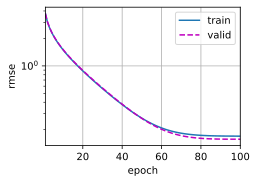

In [30]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

用k折交叉验证确定好超参数后，就可以在整个数据集上训练了，并且使用原始 test 数据进行预测并写入文件

In [47]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size) #训练
    d2l.plot([train_ls], xlabel='epoch',ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) #这里preds的结构外面还裹着一层[]，因此要取第一行,Series就是一维数据结构
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1) #拼接 Id 和 预测房价
    submission.to_csv('submission.csv', index=False)

训练log rmse: 0.162259


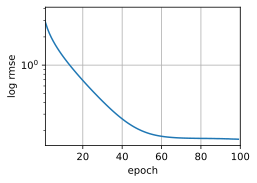

In [48]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

### 总结
1. 写了一个下载（获取缓存）字典中数据集的函数，还有解压缩的函数，为了方便以后下载数据集并保存，但 `DATA_HUB` 是不是也要在文件中？
2. 下载房价的训练和测试数据集
3. 清洗训练和测试数据集，具体有把每个数字型特征单位正态分布化，非数字型特征进行 `one-hot` 编码
4. 定义相对误差 loss
5. k 折交叉验证确定参数
6. 在整个数据集上训练并得出预测数据并